# Sentiment Analysis

Sentiment analysis is the process of exteacting the information or it says the sentiment from the texts. For doing the analysis process it required various steps of Natural Language Processing like,text cleaning,text vatorization,tokenization,padding and many more. We'll use the above steps to generate the model that gives the rating prediction.

In this model i've used two networks,first is the RNN network and second one is the LSTM model.These models uses previous information to give the output.

## Importing important libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from tensorflow import keras 
import seaborn as sns
from keras.layers import Dense, Dropout, BatchNormalization, LSTM, Embedding,SimpleRNN
from keras.models import Sequential
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [2]:
data = pd.read_csv("C:/Users/anuj verma/Downloads/Amazon-product-reviews.csv")
data.head(1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [3]:
print("Null values:\n",data.isna().sum())

data = data.dropna()

print("After dropping null values:\n", data.isna().sum())

Null values:
 Review       1
Sentiment    0
dtype: int64
After dropping null values:
 Review       0
Sentiment    0
dtype: int64


In [4]:
data['Sentiment'].value_counts()

Sentiment
1    5000
2    5000
3    5000
4    5000
5    4999
Name: count, dtype: int64

In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')

print(nltk.data.find('tokenizers/punkt'))

C:\Users\anuj verma\AppData\Roaming\nltk_data\tokenizers\punkt


[nltk_data] Downloading package punkt to C:\Users\anuj
[nltk_data]     verma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\anuj
[nltk_data]     verma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Data Cleaning

In [6]:
stop_words = set(stopwords.words('english'))


def clean_reviews(text):
    if isinstance(text, str):
        text = text.lower()
        text = word_tokenize(text)
        text = [word for word in text if word not in stop_words]
    else:
        text = []

    return text

data['Review'] = data['Review'].astype(str)
data['Review'] = data['Review'].fillna('')

data['Review'] = data['Review'].apply(clean_reviews)
        

## Tokenization and Padding

In this step we'll use tokenization to first generate the tokens and then padded the text sequences. For this we will use the tokenizer from tensorflow library

In [7]:
tokenizer = Tokenizer()
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

max_length = 500
padd_sequences = pad_sequences(text_sequences, maxlen=max_length)
text_sequences = np.array(padd_sequences)


data = pd.get_dummies(data, columns =['Sentiment'])

X = pad_sequences(text_sequences, maxlen=max_length)
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4', 'Sentiment_5']]

print(X.shape, y.shape)
print(type(text_sequences))
print(text_sequences.shape)

(24999, 500) (24999, 5)
<class 'numpy.ndarray'>
(24999, 500)


In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


## Building the RNN model

In [15]:
rnn = Sequential()

rnn.add(Embedding(len(tokenizer.word_index)+1, max_length, input_length=max_length))

rnn.add(SimpleRNN(128, activation="relu", return_sequences=True))

rnn.add(SimpleRNN(64, activation="relu", return_sequences=False))

rnn.add(Dense(5, activation="softmax"))

print(rnn.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Compilation and training

In [17]:
rnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = rnn.fit(X_train,y_train, batch_size=64, epochs=3, validation_data=(X_test,y_test), verbose=1)

print("Simple RNN score-->", rnn.evaluate(X_test,y_test))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 238s 741ms/step - accuracy: 0.2848 - loss: 1.5044 - val_accuracy: 0.3946 - val_loss: 1.3306
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 236s 755ms/step - accuracy: 0.4708 - loss: 1.1938 - val_accuracy: 0.4164 - val_loss: 1.2940
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 227s 724ms/step - accuracy: 0.6200 - loss: 0.9325 - val_accuracy: 0.4152 - val_loss: 1.4082
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.4052 - loss: 1.4064
Simple RNN score--> [1.4081499576568604, 0.41519999504089355]


## Building the LSTM Model

In [10]:
model = Sequential(name="LSTM")

model.add(Embedding(len(tokenizer.word_index)+1, max_length, input_length=max_length))

model.add(LSTM(150, return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

model.add(Dense(50, activation="relu"))
BatchNormalization()
model.add(Dropout(0.5))

model.add(Dense(5, activation="softmax"))

print(model.summary())


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Compilation and training

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train,y_train, batch_size=64, validation_data=(X_test,y_test), epochs=5, verbose=1)

print("model accuracy score-->", model.evaluate(X_test, y_test))

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.3147 - loss: 1.4930 - val_accuracy: 0.4414 - val_loss: 1.2415
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.5081 - loss: 1.1397 - val_accuracy: 0.4524 - val_loss: 1.2543
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.6186 - loss: 0.9514 - val_accuracy: 0.4522 - val_loss: 1.3394
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.6909 - loss: 0.8024 - val_accuracy: 0.4408 - val_loss: 1.4276
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7732 - loss: 0.6126 - val_accuracy: 0.4460 - val_loss: 1.7393
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.4426 - loss: 1.7357
model accuracy score--> [1.7393462657928467, 0.44600000977516174]


## plotting the accuracies and losses

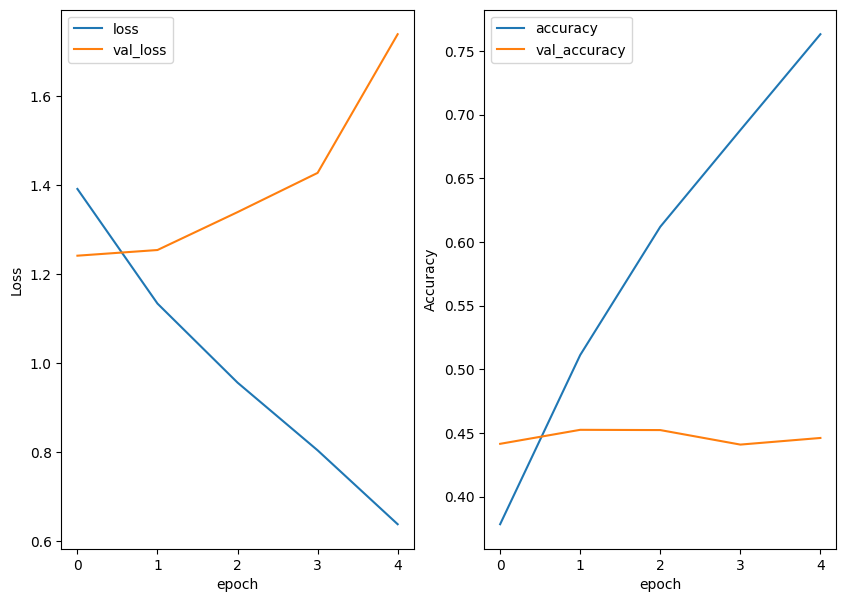

In [18]:
metrics = history.history
plt.figure(figsize=(10,7))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel("epoch")
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel("epoch")
plt.ylabel('Accuracy')
plt.savefig("LSTM accuracy plt.png", dpi=300, bbox_inches="tight")

## Confusion matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step


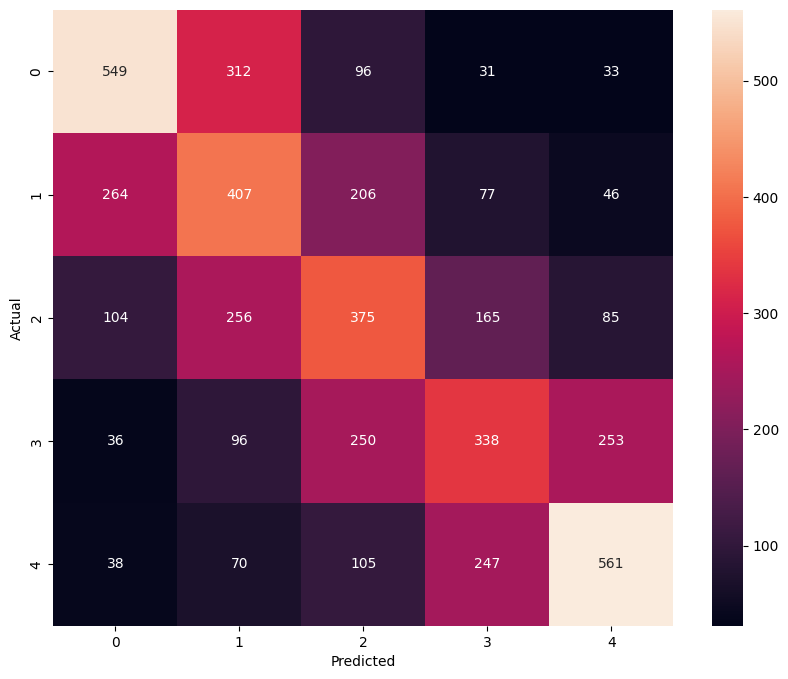

In [20]:
y_true = np.argmax(y_test, axis=1)
y_true.shape

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true,y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("Confusion matrix.png",dpi=300,bbox_inches="tight")
plt.show()

## Testing the Model

Let's take a look of how the model performing on the given texts. I'll use the following function to generate the model's prediction and give us the rating.

In [11]:
def prediction(text):
    test_sequences = tokenizer.texts_to_sequences([text])

    testing = pad_sequences(test_sequences, maxlen=max_length)

    y_pred = np.argmax(model.predict(testing), axis=1)

    return y_pred[0]+1

test1 = prediction('this was sooo good')
print('The rating of the sentence is:', test1)

test2 = prediction('i hate that thing')
print('The rating of the sentence is:', test2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The rating of the sentence is: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
The rating of the sentence is: 5
